In [22]:
# Import all of the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import format_number
from pyspark.sql.functions import mean, max, min, year
warnings.filterwarnings('ignore')

In [23]:
# Build the sparker session function and the virtual environment
aspark = SparkSession.builder.appName("Amazon Stock Analysis").getOrCreate()

In [3]:
# Get historical data
amz = yf.Ticker('AMZN')
amz_data = amz.history(period="max")

# Obeserve the first five rows
amz_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


# Exploratory Data Analysis

In [4]:
# Check the data type
amz_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7029 entries, 1997-05-15 00:00:00-04:00 to 2025-04-23 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          7029 non-null   float64
 1   High          7029 non-null   float64
 2   Low           7029 non-null   float64
 3   Close         7029 non-null   float64
 4   Volume        7029 non-null   int64  
 5   Dividends     7029 non-null   float64
 6   Stock Splits  7029 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 439.3 KB


In [5]:
# Create a variable for gather the basic statistics of the dataset
result = amz_data.describe()

# Convert the Pandas DataFrame 'result' to a PySpark DataFrame
result_spark = aspark.createDataFrame(result)

# Reset index to include 'summary' as a column in the Pandas DataFrame before converting to PySpark DataFrame
result = result.reset_index()
result_spark = aspark.createDataFrame(result)

# Display the summary statistics of the PySpark dataset
result_spark.select(result_spark['index'].alias('summary'),
              format_number(result_spark['Open'].cast('float'),2).alias('Open'),
              format_number(result_spark['High'].cast('float'),2).alias('High'),
              format_number(result_spark['Low'].cast('float'),2).alias('Low'),
              format_number(result_spark['Close'].cast('float'),2).alias('Close'),
              result_spark['Volume'].cast('int').alias('Volume')
             ).show()

+-------+--------+--------+--------+--------+----------+
|summary|    Open|    High|     Low|   Close|    Volume|
+-------+--------+--------+--------+--------+----------+
|  count|7,029.00|7,029.00|7,029.00|7,029.00|      7029|
|   mean|   41.60|   42.09|   41.07|   41.59| 135566706|
|    std|   59.15|   59.83|   58.41|   59.13| 137316670|
|    min|    0.07|    0.07|    0.07|    0.07|   9744000|
|    25%|    2.11|    2.15|    2.08|    2.12|  62626000|
|    50%|    9.13|    9.24|    9.02|    9.13| 100174000|
|    75%|   77.00|   77.85|   75.36|   76.52| 155120000|
|    max|  239.02|  242.52|  238.03|  242.06|2086584000|
+-------+--------+--------+--------+--------+----------+



In [6]:
# Convert Pandas DataFrame to PySpark DataFrame
amz_data_spark = aspark.createDataFrame(amz_data)

# Calculate 'HV Ratio' using PySpark syntax
amz2 = amz_data_spark.withColumn("HV Ratio", amz_data_spark["High"] / amz_data_spark["Volume"])

# Display the 'HV Ratio' column
amz2.select('HV Ratio').show()

+--------------------+
|            HV Ratio|
+--------------------+
|8.661788347469372...|
|3.365918385739229...|
|7.249459574512565...|
|8.002267935129854...|
|2.182441123235062...|
|3.073670382016574...|
|2.385676168932887...|
|4.730730199661432...|
|8.937893627552187...|
|1.109810513859381...|
|1.455461758588369...|
|6.470841842377968E-9|
|3.235420921188984E-9|
|1.208917653230920...|
|6.794566590033956...|
|5.470399274996087...|
|1.815837636894109...|
|7.823789334606406...|
|3.375757723946362...|
|2.521200918172504...|
+--------------------+
only showing top 20 rows



### What is the average Closing price?

In [7]:
# Calculate the average closing price
amz_data_spark.select(mean('Close')).show()

+-----------------+
|       avg(Close)|
+-----------------+
|41.59447074449174|
+-----------------+



### What is the maximum and minimum volume of stock traded?


In [8]:
# Select the highest and lowest volume of stocks
amz_data_spark.select(max("Volume"),min("Volume")).show()

+-----------+-----------+
|max(Volume)|min(Volume)|
+-----------+-----------+
| 2086584000|    9744000|
+-----------+-----------+



### What is the highest Stock Price and what year?

In [9]:
# Extract year from the 'Date' column and create a new 'Year' column
amz_data_spark = amz_data_spark.withColumn('Year', year(amz_data_spark['Date']))

# Group by 'Year' and select 'Year' and 'max(High)'
max_df = amz_data_spark.groupBy('Year').max()

# Select 'Year' and 'max(High)' from the aggregated DataFrame
max_df.select('Year','max(High)').orderBy('Year', ascending=False).show()

+----+------------------+
|Year|         max(High)|
+----+------------------+
|2025|242.52000427246094|
|2024|             233.0|
|2023| 155.6300048828125|
|2022|171.39999389648438|
|2021| 188.6540069580078|
|2020| 177.6125030517578|
|2019|101.79000091552734|
|2018| 102.5250015258789|
|2017|60.670501708984375|
|2016| 42.36050033569336|
|2015|34.821998596191406|
|2014|20.402999877929688|
|2013|  20.2814998626709|
|2012|13.205499649047852|
|2011| 12.33549976348877|
|2010| 9.282500267028809|
|2009| 7.295499801635742|
|2008| 4.871500015258789|
|2007| 5.054500102996826|
|2006| 2.428999900817871|
+----+------------------+
only showing top 20 rows



# Linear Regression

In [24]:
# Rename the Close column to a label column
amz_data_spark = amz_data_spark.withColumnRenamed("Close", "label")

# Create a VectorAssembler object to combine the specified input columns into a single 'features' column
assembler = VectorAssembler(inputCols=["Open","High","Low","Volume"], outputCol="features")

# Apply transform on the PySpark DataFrame
output = assembler.transform(amz_data_spark)
final_data = output.select("features", "label")

In [11]:
# Split the dataset into a training and test
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [12]:
# Initializing a Linear Regression model
ss = LinearRegression(featuresCol='features', labelCol='label')

In [13]:
# Training the model
ss = ss.fit(train_data)

In [14]:
# Print model coefficients and intercept
print("Coefficients:", str(ss.coefficients))
print("Intercept:", str(ss.intercept))

Coefficients: [-0.5934708588430375,0.7990414964969189,0.7949568261784068,-3.4927041203543455e-12]
Intercept: 0.0023296136346943456


In [25]:
# Evaluate the model's performance on the test data
pred = ss.evaluate(test_data)

# Display the predictions made by the model on the test data
pred.predictions.show()

+--------------------+-------------------+-------------------+
|            features|              label|         prediction|
+--------------------+-------------------+-------------------+
|[0.0703129991889,...|0.07500000298023224|0.07324571491570915|
|[0.07083299756050...|0.07708299905061722|0.07614185134121022|
|[0.07552099972963...|0.07552099972963333|0.07823880242038538|
|[0.07552099972963...|0.07708299905061722|0.07999341448509939|
|[0.07552099972963...|0.07916700094938278|0.08062312586890287|
|[0.07578100264072...|0.07942699640989304|0.08079457455458189|
|[0.07578100264072...|0.08281300216913223|0.08509809583177647|
|[0.07916700094938...|0.08020800352096558|0.08267885705657456|
|[0.08020800352096...|0.07864599674940109|0.08086023536057788|
|[0.08124999701976...|0.07656300067901611| 0.0799932708149814|
|[0.10468800365924...|0.10833299905061722|0.10992377384701998|
|[0.10885400325059...|0.10911499708890915|0.11079174940747101|
|[0.10885400325059...|0.10781300067901611| 0.1118048148

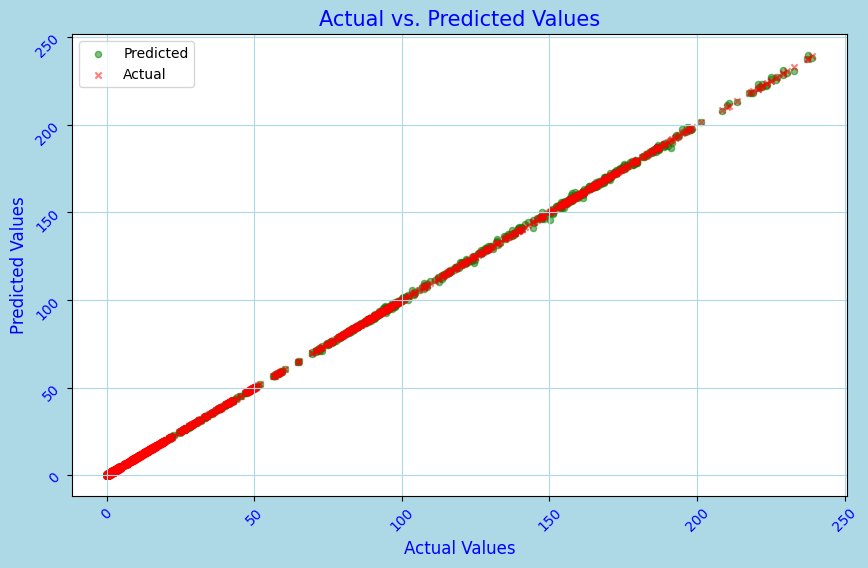

In [16]:
# Plot the linear regression of the actual vs predicted values
plt.figure(figsize=(10, 6), facecolor='lightblue')
plt.scatter(pred.predictions.select('label').toPandas(), pred.predictions.select('prediction').toPandas(), alpha=0.5, marker='o', s=20, c='green', label='Predicted')
plt.scatter(pred.predictions.select('label').toPandas(), pred.predictions.select('label').toPandas(), alpha=0.5, marker='x', s=20, c='red', label='Actual')

plt.xlabel('Actual Values', color = 'blue', fontsize = 12)
plt.ylabel('Predicted Values', color = 'blue', fontsize = 12)
plt.title('Actual vs. Predicted Values', fontsize = 15, color = 'blue')
plt.xticks(rotation=45, color = 'blue')
plt.yticks(rotation=45, color = 'blue')
plt.grid(True, color = 'lightblue')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the training data
pred_train = ss.evaluate(train_data)

In [18]:
# Printing MAE
print('MAE for train set:', pred_train.meanAbsoluteError)
print('MAE for test set:', pred.meanAbsoluteError)

MAE for train set: 0.2178945581333791
MAE for test set: 0.22753587893566926


In [19]:
# Printing MSE
print('MSE for train set:', pred_train.meanSquaredError)
print('MSE for test set:', pred.meanSquaredError)

MSE for train set: 0.24880952616829402
MSE for test set: 0.25588904013596314


In [20]:
# Printing RMSE
print('RMSE for train set:', pred_train.rootMeanSquaredError)
print('RMSE for test set:', pred.rootMeanSquaredError)

RMSE for train set: 0.4988081055559282
RMSE for test set: 0.5058547618990683


In [21]:
# Printing the R2 Score
print('R2-Score for train set:', pred_train.r2)
print('R2-Score for test set:', pred.r2)

R2-Score for train set: 0.9999280648378985
R2-Score for test set: 0.9999285285545458
